#Primeira GAN

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np

# carregamento da base MNIST
(X_train, _), _ = keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32) / 255.

BATCH_SIZE = 128

dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(1)

#checando o data generator
for k,sample in enumerate(dataset):
  print(sample.shape)
  if k == 3: break 

11501568/11490434 [==============================] - 0s 0us/step
(128, 28, 28)
(128, 28, 28)
(128, 28, 28)
(128, 28, 28)


In [ ]:
#codificando a rede geradora
class GeneratorNetw(tf.keras.models.Model):
    
    def __init__(self, random_normal_dim = 32):
        super(GeneratorNetw, self).__init__()
        self.dense1 = tf.keras.layers.Dense(64, activation="selu")
        self.dense2 = tf.keras.layers.Dense(128, activation="selu")
        self.dense3 = tf.keras.layers.Dense(28*28, activation="sigmoid")
        self.reshape= tf.keras.layers.Reshape([28,28])

    def compute_output_shape(self, input_shape):
        return (input_shape[0], 28,28)

    def call(self, x):
        y = self.dense1(x)
        y = self.dense2(y)
        y = self.dense3(y)
        y = self.reshape(y)
        return y

In [ ]:
#codificando a rede discriminadora

class DiscriminatorNetw(tf.keras.models.Model):

  def __init__(self):
    super(DiscriminatorNetw, self).__init__()
    self.flat = tf.keras.layers.Flatten(input_shape=[28, 28])
    self.dense1 = tf.keras.layers.Dense(128, activation="selu")
    self.dense2 = tf.keras.layers.Dense(64, activation="selu")
    self.dense3 = tf.keras.layers.Dense(1, activation="sigmoid")

  def compute_output_shape(self, input_shape):
    return (input_shape[0], 1)
      
  def call(self,x):
    y = self.flat(x)
    y = self.dense1(y)
    y = self.dense2(y)
    y = self.dense3(y)
    return y

In [ ]:
#codificando GAN

class GANNetw(tf.keras.models.Model):

  def __init__(self, generator, discriminator):
    super(GANNetw, self).__init__()
    self.gen = generator
    self.disc = discriminator

  def compute_output_shape(self, input_shape):
    return (input_shape[0], 1) 

  def call(self,x):
    y = self.gen(x)
    y = self.disc(y)
    return y

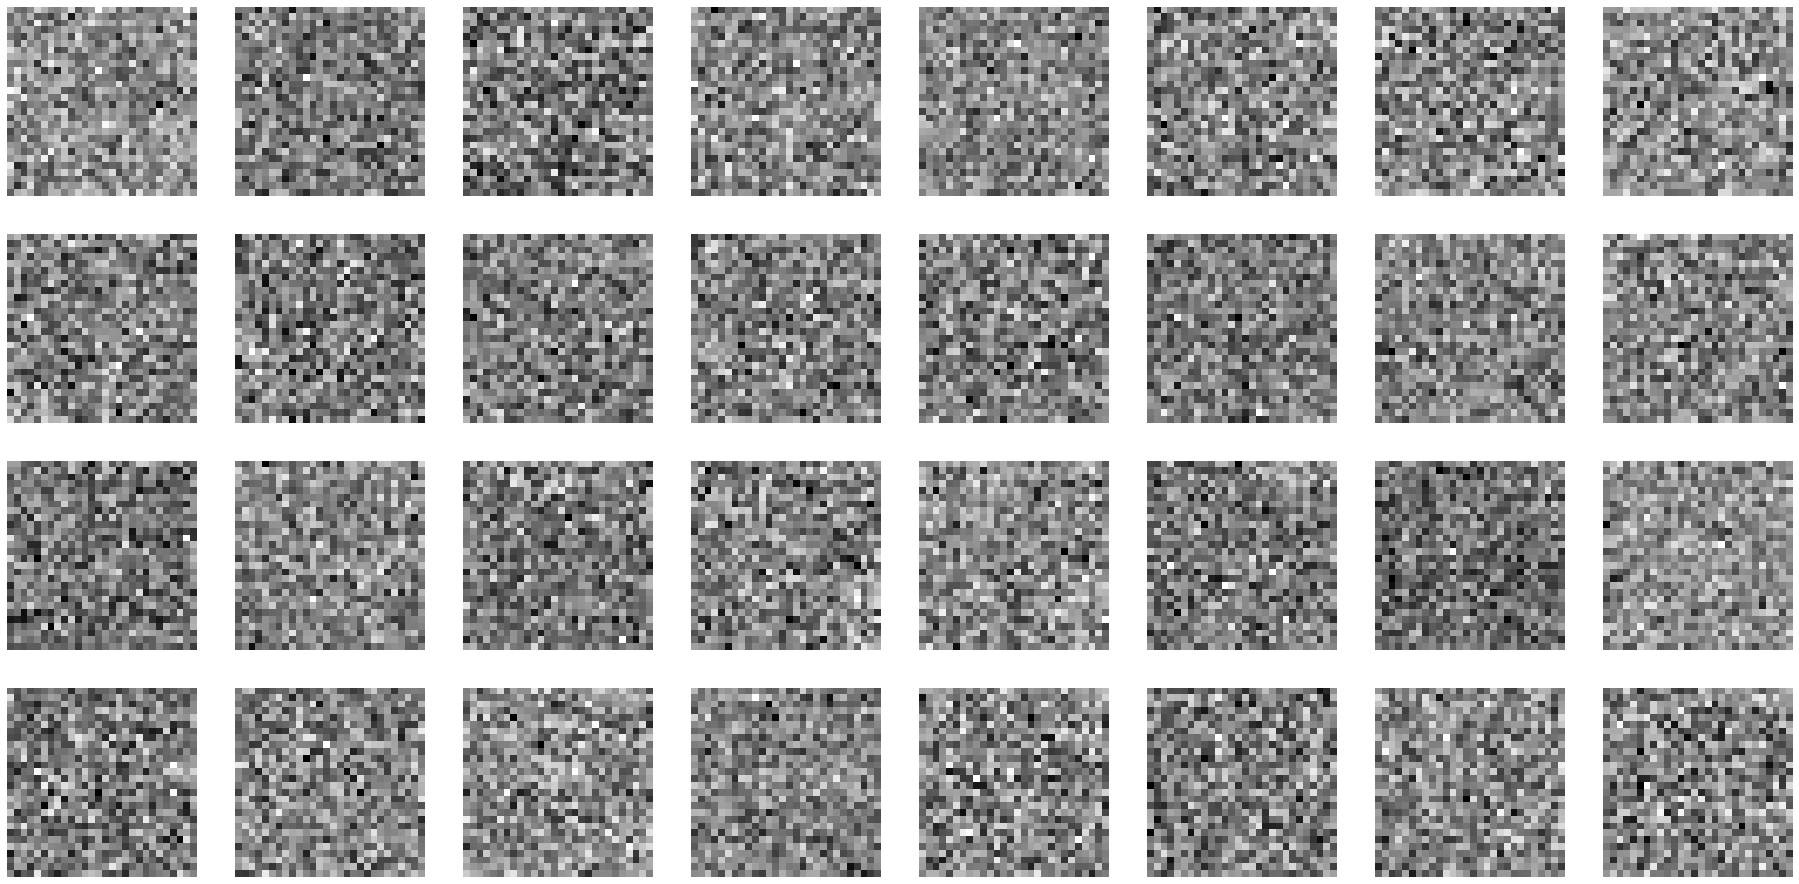

In [ ]:
import matplotlib.pyplot as plt
from IPython import display

#funcao auxiliar de plotagem
def plot_multiple_images(images, n_cols=None):
    '''visualizes fake images'''
    display.clear_output(wait=False)  
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1

    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)

    plt.figure(figsize=(4*n_cols, 4*n_rows))
    
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

# generate a batch of noise input (batch size = 16)
random_normal_dimensions = 32
test_noise = tf.random.normal([32, random_normal_dimensions])

# feed the batch to the untrained generator
gen = GeneratorNetw()
test_image = gen(test_noise)

# visualize sample output
plot_multiple_images(test_image, n_cols=8)

In [ ]:
def train_gan(gan, dataset, random_normal_dimensions, n_epochs=50):
    """ Defines the two-phase training loop of the GAN
    Args:
      gan -- the GAN model which has the generator and discriminator
      dataset -- the training set of real images
      random_normal_dimensions -- dimensionality of the input to the generator
      n_epochs -- number of epochs
    """

    # get the two sub networks from the GAN model
    generator, discriminator = gan.layers

    # start loop
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))       
        for real_images in dataset:
            # infer batch size from the training batch
            batch_size = real_images.shape[0]

            # Train the discriminator - PHASE 1
            # Create the noise
            noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])
            
            # Use the noise to generate fake images
            fake_images = generator(noise)
            
            # Create a list by concatenating the fake images with the real ones
            mixed_images = tf.concat([fake_images, real_images], axis=0)
            
            # Create the labels for the discriminator
            # 0 for the fake images
            # 1 for the real images
            discriminator_labels = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            
            # Ensure that the discriminator is trainable
            discriminator.trainable = True
            
            # Use train_on_batch to train the discriminator with the mixed images and the discriminator labels
            discriminator.train_on_batch(mixed_images, discriminator_labels)
            
            # Train the generator - PHASE 2
            # create a batch of noise input to feed to the GAN
            noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])

            # label all generated images to be "real" because the generator ultimate goal is that all samples created by it  
            # be evaluated as '1' in the discriminator
            generator_labels = tf.constant([[1.]] * batch_size)

            # Freeze the discriminator
            discriminator.trainable = False

            # Train the GAN on the noise with the labels all set to be true
            gan.train_on_batch(noise, generator_labels)

        # plot the fake images used to train the discriminator
        plot_multiple_images(fake_images, 8)                     
        plt.show()      

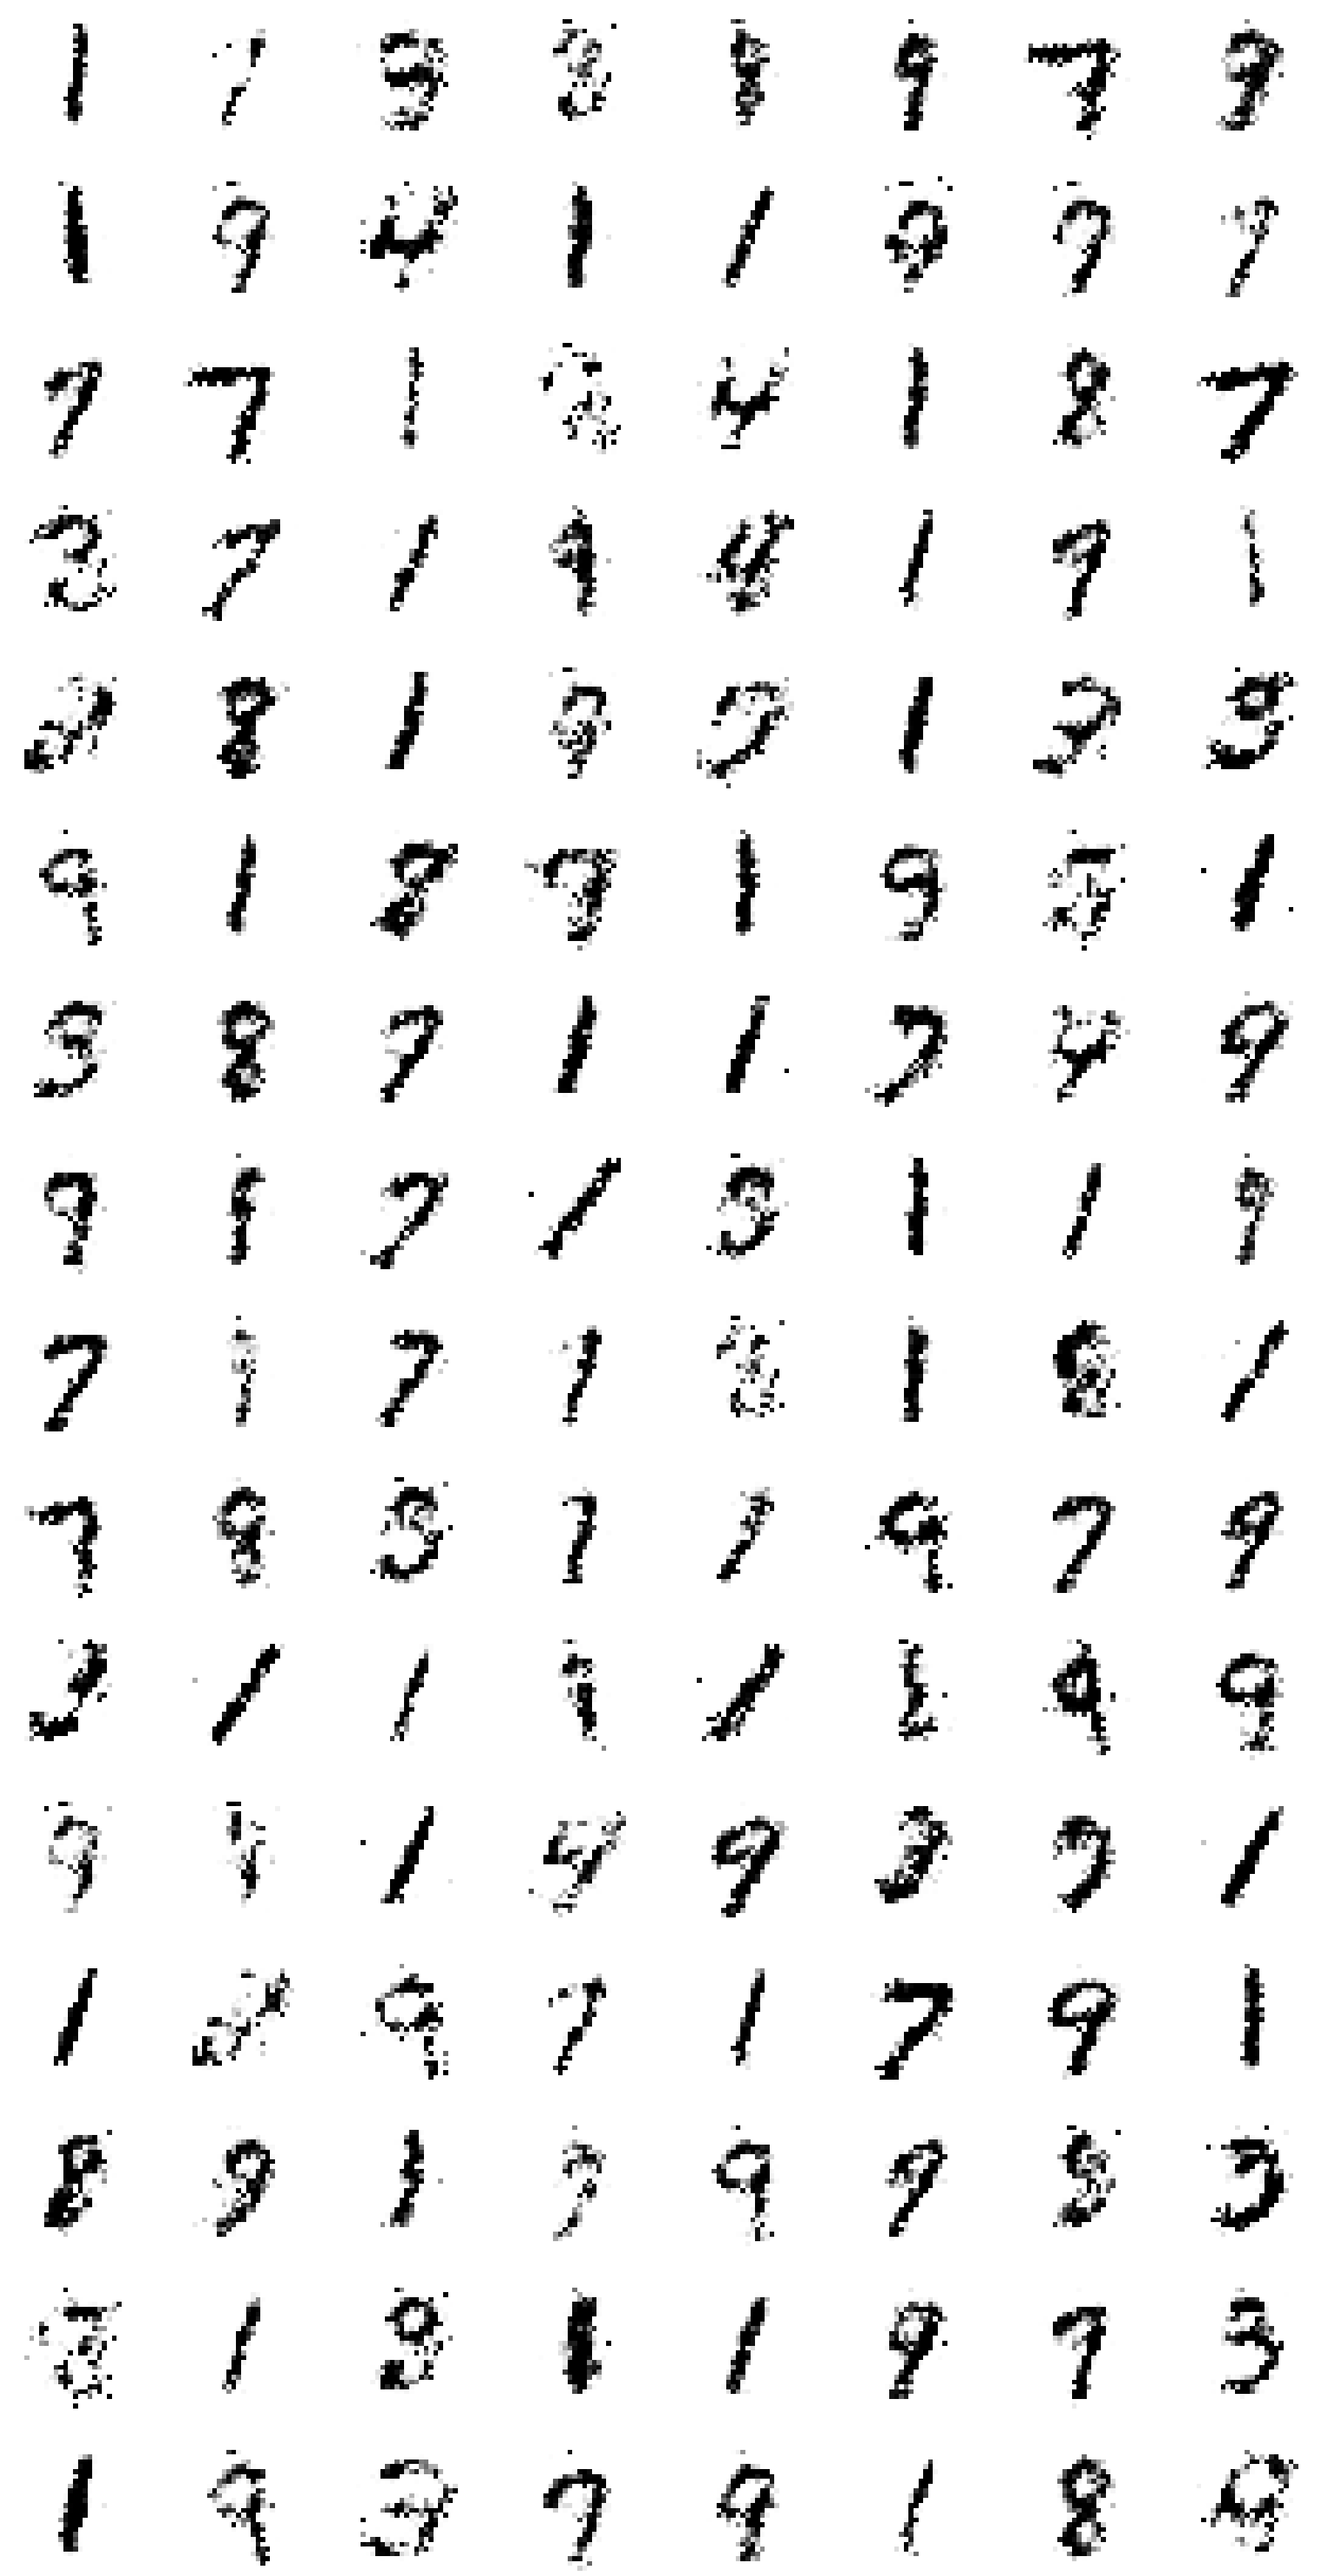

In [ ]:
disc = DiscriminatorNetw()
disc.compile(loss="binary_crossentropy", optimizer="rmsprop")
disc.trainable = False

gan = GANNetw(generator=gen, discriminator=disc)
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")


train_gan(gan, dataset, random_normal_dimensions, n_epochs=20)